In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pycaret.time_series import TSForecastingExperiment
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots
from datetime import datetime
import sys  
from pathlib import Path
from pycaret.regression import *
import shap
import matplotlib.pyplot as plt
import logging
import pickle

# Add project root to path (assuming notebook is in the notebooks directory)
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Local imports
from src.core.bloomberg_fetcher import fetch_bloomberg_data
from src import trans_utils  # Using the one from src root since that's what you have open
from src.utils import merge_utils  # Using the one from utils since that's what you have open
from src.utils.csv_exporter import export_to_csv

In [2]:
# Getting all the data 
mapping = {
    ('I05510CA Index', 'INDEX_OAS_TSY_BP'): 'cad_oas',
    ('LF98TRUU Index', 'INDEX_OAS_TSY_BP'): 'us_hy_oas',
    ('LUACTRUU Index', 'INDEX_OAS_TSY_BP'): 'us_ig_oas',
    ('SPTSX Index', 'PX_LAST'): 'tsx',
    ('VIX Index', 'PX_LAST'): 'vix',
    ('USYC3M30 Index', 'PX_LAST'): 'us_3m_10y',
    ('BCMPUSGR Index', 'PX_LAST'): 'us_growth_surprises',
    ('BCMPUSIF Index', 'PX_LAST'): 'us_inflation_surprises',
    ('LEI YOY  Index', 'PX_LAST'): 'us_lei_yoy',
    ('.HARDATA G Index', 'PX_LAST'): 'us_hard_data_surprises',
    ('CGERGLOB Index', 'PX_LAST'): 'us_equity_revisions',
    ('.ECONREGI G Index', 'PX_LAST'): 'us_economic_regime',
 
}

# Calculate dates
end_date = datetime.now().strftime('%Y-%m-%d')
start_date ='2002-01-01'

# Fetch the data
df = fetch_bloomberg_data(
    mapping=mapping,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Getting all the er_ytd data 
mapping1 = {
    ('I05510CA Index', 'INDEX_EXCESS_RETURN_YTD'): 'cad_ig_er',
    ('LF98TRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_hy_er',
    ('LUACTRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_ig_er',
}

# Fetch the er_ytd_data
df1 = fetch_bloomberg_data(
    mapping=mapping1,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Conver er_ytd data to an index
df2= trans_utils.convert_er_ytd_to_index(df1[['cad_ig_er','us_hy_er','us_ig_er']])
final_df=merge_utils.merge_dfs(df, df2, fill='ffill', start_date_align='yes')

# Handle bad data point for cad_oas on Nov 15 2005
bad_date = '2005-11-15'
if bad_date in final_df.index:
    final_df.loc[bad_date, 'cad_oas'] = final_df.loc[final_df.index < bad_date, 'cad_oas'].iloc[-1]


#  Fill the first row with 100 (starting index value)
final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']] = final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']].fillna(100)
# Drop the er_index columns
final_df = final_df.drop(['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index'], axis=1)


# Calculate TSX percent changes for different periods
final_df['tsx_1m'] = final_df['tsx'].pct_change(periods=1) * 100
final_df['tsx_3m'] = final_df['tsx'].pct_change(periods=3) * 100
final_df['tsx_6m'] = final_df['tsx'].pct_change(periods=6) * 100
final_df['tsx_12m'] = final_df['tsx'].pct_change(periods=12) * 100

# Drop the original tsx column
final_df = final_df.drop('tsx', axis=1)

# Drop any NA rows that resulted from the calculations
final_df = final_df.dropna()

# Export the final DataFrame to CSV, overwriting if exists
export_path = export_to_csv(
    data=final_df,
    name='monthly_oas_pycaret',
    export_dir='c:/Users/Eddy/Documents/auto_ml/csv_outputs',
    overwrite=True  # Explicitly set to overwrite existing file
)

print(final_df.info())
print('-----------------------------')
print('-----------------------------')
print(final_df.head())
print('-----------------------------')
print('-----------------------------')
print(final_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 2003-08-29 to 2025-01-31
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cad_oas                 332 non-null    float64
 1   us_hy_oas               332 non-null    float64
 2   us_ig_oas               332 non-null    float64
 3   vix                     332 non-null    float64
 4   us_3m_10y               332 non-null    float64
 5   us_growth_surprises     332 non-null    float64
 6   us_inflation_surprises  332 non-null    float64
 7   us_lei_yoy              332 non-null    float64
 8   us_hard_data_surprises  332 non-null    float64
 9   us_equity_revisions     332 non-null    float64
 10  us_economic_regime      332 non-null    float64
 11  tsx_1m                  332 non-null    float64
 12  tsx_3m                  332 non-null    float64
 13  tsx_6m                  332 non-null    float64
 14  tsx_12m                

In [6]:
import pandas as pd
import logging
import pickle
import os
from pycaret.regression import setup, compare_models, finalize_model, predict_model, pull

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


def load_and_prepare_data(file_path):
    """
    Load and prepare the data for time series modeling
    
    Args:
        file_path: Path to the CSV file containing the data
        
    Returns:
        pd.DataFrame: Prepared dataframe with datetime index
    """
    try:
        logging.info(f"Loading data from {file_path}")
        df = pd.read_csv(file_path)
        
        # Convert Date column to datetime and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Sort index to ensure chronological order
        df = df.sort_index()
        
        # Ensure monthly frequency and forward fill any missing values
        df = df.asfreq('M', method='ffill')
        
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

def train_predict_model(data):
    """
    Train a regression model and make predictions
    
    Args:
        data: DataFrame with the data
        
    Returns:
        tuple: (final_model, model_metrics)
    """
    try:
        logging.info("Initializing model setup")
        s = setup(
            data=data,
            target='cad_oas',
            fold=3,
            fold_strategy='kfold',  # Changed to kfold
            transform_target=None,
            session_id=123,
            verbose=True
        )
        
        # Include only the ML models we know work with our setup
        include = [
            'lr', 'en', 'ridge', 'lasso', 'br',  # Linear models
            'huber', 'omp', 'knn',  # Other regression models
            'dt', 'rf', 'et', 'gbr',  # Tree models
            'ada', 'lightgbm', 'catboost'  # Boosting models
        ]
        
        # Compare models
        logging.info("Training and comparing models")
        best_model = compare_models(include=include)
        
        # Get model performance metrics
        logging.info("Getting model performance metrics")
        model_metrics = pull()
        
        # Finalize the best model
        logging.info("Finalizing best model")
        final_model = finalize_model(best_model)
        
        return final_model, model_metrics
    except Exception as e:
        logging.error(f"Error in model training/prediction: {str(e)}")
        raise

def save_model_to_pkl(model, filename='regression_best_model.pkl'):
    """
    Save a trained model to a pickle file
    
    Args:
        model: Trained model to save
        filename: Name of the pickle file
    """
    try:
        # Create models directory if it doesn't exist
        os.makedirs('models', exist_ok=True)
        
        # Create full path
        model_path = os.path.join('models', filename)
        
        logging.info(f"Saving model to {os.path.abspath(model_path)}")
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        logging.info("Model saved successfully")
        
    except Exception as e:
        logging.error(f"Error saving model to pickle file: {str(e)}")
        raise

def analyze_model_performance(model, data):
    """
    Analyze model performance metrics and make predictions
    
    Args:
        model: Trained model from PyCaret
        data: Training data DataFrame
    """
    try:
        # Get performance metrics
        metrics = pull()
        print("\nModel Performance Metrics:")
        print(metrics)
        
        # Get exogenous variables for prediction
        exog_data = data.drop('cad_oas', axis=1).iloc[-1:].copy()
        
        # Make predictions
        logging.info("Making predictions")
        predictions = predict_model(model, data=exog_data)  # Changed to data=exog_data
        
        # Save predictions
        csv_path = 'csv_outputs/cad_oas_predictions.csv'
        os.makedirs(os.path.dirname(csv_path), exist_ok=True)  # Create directory if it doesn't exist
        predictions.to_csv(csv_path)
        logging.info(f"Predictions saved to {os.path.abspath(csv_path)}")
        
        # Get last actual and predicted values
        last_actual = data['cad_oas'].iloc[-1]
        # Get the prediction column (should be the last column)
        pred_col = predictions.columns[-1]
        next_pred = predictions[pred_col].iloc[-1]
        
        print("\nPrediction Results:")
        print(f"Last actual value: {last_actual:.4f}")
        print(f"Predicted next value: {next_pred:.4f}")
        
    except Exception as e:
        logging.error(f"Error analyzing model performance: {str(e)}")
        raise

def main():
    """
    Main function to orchestrate the model training and prediction process
    """
    global model  # Use the global model variable
    try:
        # File path
        file_path = 'c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv'
        
        # Load and prepare data
        data = load_and_prepare_data(file_path)
        
        # Train model and get predictions
        model, metrics = train_predict_model(data)
        
        # Save the model to pickle file
        save_model_to_pkl(model, 'regression_best_model.pkl')
        
        # Analyze model performance
        analyze_model_performance(model, data)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-02-15 09:42:22,050 - INFO - Loading data from c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv
2025-02-15 09:42:22,056 - INFO - Data loaded successfully. Shape: (258, 15)
2025-02-15 09:42:22,057 - INFO - Initializing model setup


,Description,Value
0,Session id,123
1,Target,cad_oas
2,Target type,Regression
3,Original data shape,"(258, 15)"
4,Transformed data shape,"(258, 15)"
5,Transformed train set shape,"(180, 15)"
6,Transformed test set shape,"(78, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


2025-02-15 09:42:22,971 - INFO - Training and comparing models


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,8.7458,152.3989,12.3141,0.9419,0.1135,0.0823,0.0333
gbr,Gradient Boosting Regressor,9.9390,181.8314,13.3894,0.9302,0.1215,0.0901,0.0300
rf,Random Forest Regressor,10.9676,206.8972,14.2826,0.9238,0.1339,0.1029,0.0433
catboost,CatBoost Regressor,9.3836,214.3108,14.2191,0.9210,0.1115,0.0827,0.5633
lr,Linear Regression,12.0047,241.5198,15.4715,0.9069,0.1584,0.1217,0.0100
ridge,Ridge Regression,12.2510,247.1020,15.6613,0.9045,0.1626,0.1262,0.0067
lasso,Lasso Regression,13.0072,276.8943,16.5963,0.8932,0.1732,0.1355,0.0100
en,Elastic Net,13.3230,295.4205,17.1438,0.8866,0.1797,0.1396,0.0067
ada,AdaBoost Regressor,14.5680,314.8332,17.6619,0.8828,0.1619,0.1343,0.0233
br,Bayesian Ridge,14.2851,348.1175,18.6138,0.8663,0.1944,0.1502,0.0167


2025-02-15 09:42:27,938 - INFO - Getting model performance metrics
2025-02-15 09:42:27,939 - INFO - Finalizing best model
2025-02-15 09:42:28,269 - INFO - Saving model to c:\Users\Eddy\Documents\auto_ml\notebooks\models\regression_best_model.pkl
2025-02-15 09:42:28,271 - INFO - Model saved successfully
2025-02-15 09:42:28,278 - INFO - Making predictions



Model Performance Metrics:
                                    Model      MAE       MSE     RMSE      R2  \
et                  Extra Trees Regressor   8.7458  152.3989  12.3141  0.9419   
gbr           Gradient Boosting Regressor   9.9390  181.8314  13.3894  0.9302   
rf                Random Forest Regressor  10.9676  206.8972  14.2826  0.9238   
catboost               CatBoost Regressor   9.3836  214.3108  14.2191  0.9210   
lr                      Linear Regression  12.0047  241.5198  15.4715  0.9069   
ridge                    Ridge Regression  12.2510  247.1020  15.6613  0.9045   
lasso                    Lasso Regression  13.0072  276.8943  16.5963  0.8932   
en                            Elastic Net  13.3230  295.4205  17.1438  0.8866   
ada                    AdaBoost Regressor  14.5680  314.8332  17.6619  0.8828   
br                         Bayesian Ridge  14.2851  348.1175  18.6138  0.8663   
knn                 K Neighbors Regressor  14.7629  410.5122  19.9314  0.8499   


2025-02-15 09:42:28,437 - INFO - Predictions saved to c:\Users\Eddy\Documents\auto_ml\notebooks\csv_outputs\cad_oas_predictions.csv



Prediction Results:
Last actual value: 101.6196
Predicted next value: 101.6196


In [8]:

# functional API
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

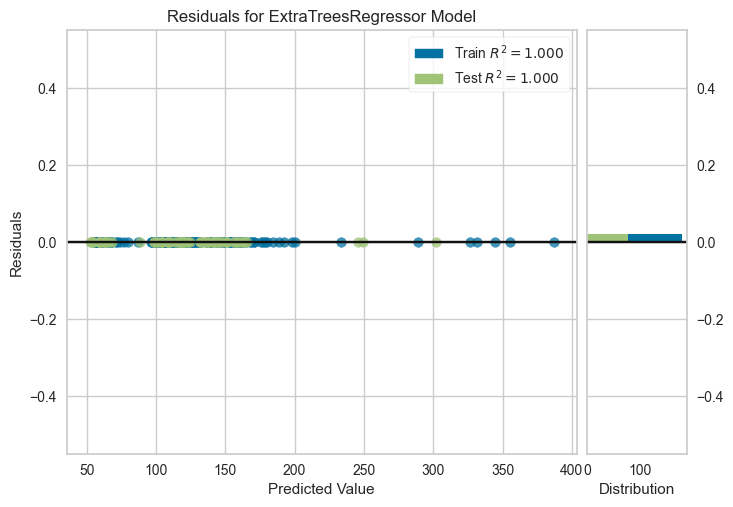

In [9]:
# functional API
plot_model(model, plot = 'residuals')